# Prerrequisitos

In [9]:
from leiden import Leiden
from nsga import NSGA
from moga import MOGA
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
# Carga del grafo
graph = nx.read_graphml("data/amazon_graph.graphml")

# Renombramos los nodos al rango [0, N]
mapping = {node: i for i, node in enumerate(graph.nodes())}
graph = nx.relabel_nodes(graph, mapping)

# NSGA-II

## Execute algorithm

Generación 0


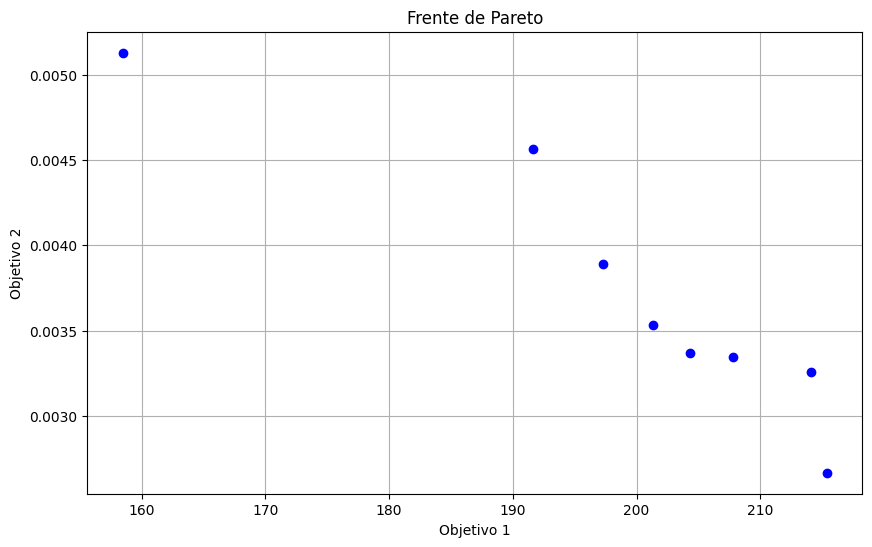

Generación 624


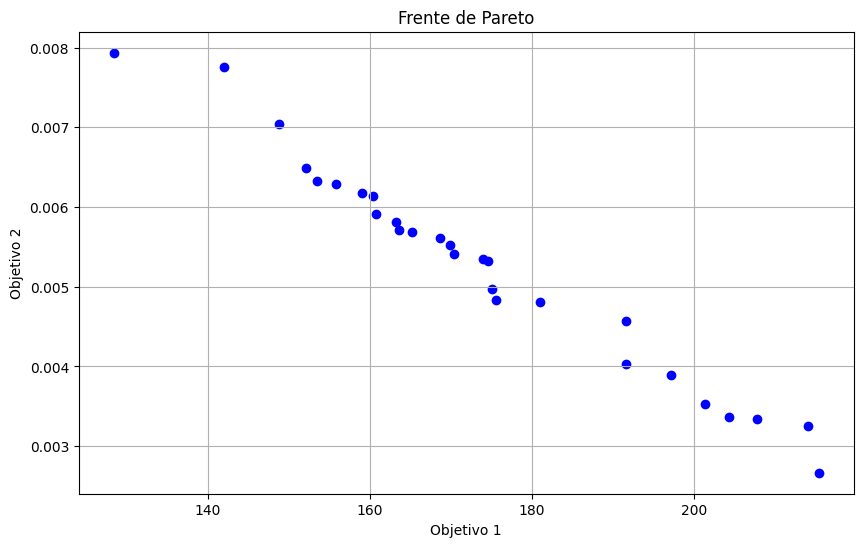

In [16]:
es = NSGA(graph, N=80, init=0.4, pcross=0.6, pmut=0.4, n_iter=625, fitness_metrics=3, n_tour=2, crossover_op=2, show_plot=624)
pop, old_fitness, pareto = es.evolve()

### Save data

In [17]:
# # Save results with pickle
with open('results/pop_nsga_3.pkl', 'wb') as file_pop:
    pickle.dump(pop, file_pop)

with open('results/fitness_nsga_3.pkl', 'wb') as file_fitness:
    pickle.dump(old_fitness, file_fitness)

with open('results/pareto_nsga_3.pkl', 'wb') as file_pareto:
    pickle.dump(pareto, file_pareto)

### Retrieve saved data

In [12]:
# Read results with pickle
with open('results/pop_nsga_0.pkl', 'rb') as file_pop:
    pop = pickle.load(file_pop)

with open('results/fitness_nsga_0.pkl', 'rb') as file_fitness:
    old_fitness = pickle.load(file_fitness)

with open('results/pareto_nsga_0.pkl', 'rb') as file_pareto:
    pareto = pickle.load(file_pareto)

# MOGA

## Execute algorithm

Generación 0


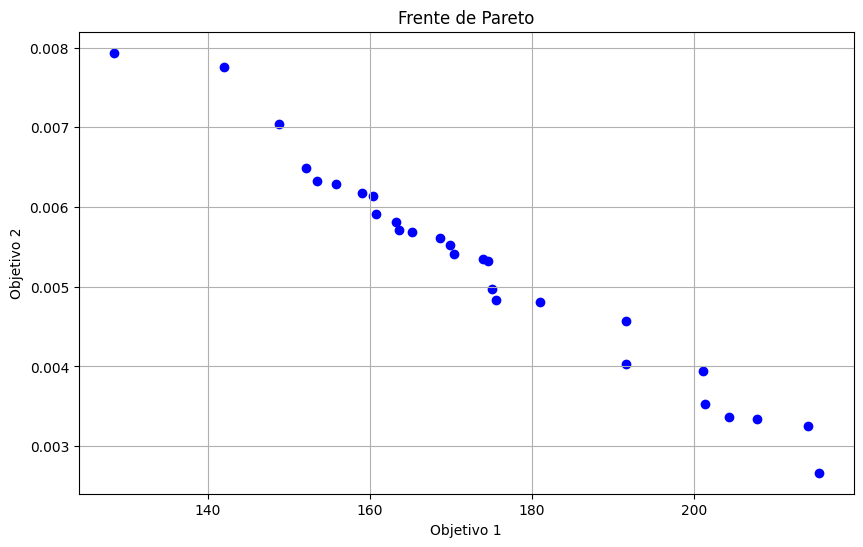

Generación 624


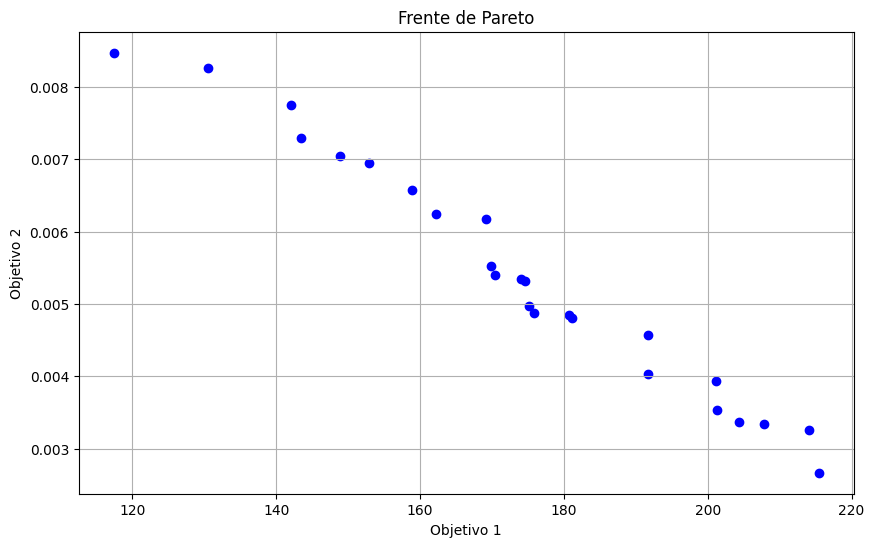

In [18]:
es2 = MOGA(graph, N=100, init=0.5, pcross=0.55, pmut=0.4, n_iter=500, fitness_metrics=2, n_tour = 2, crossover_op=2, sigma=0.7, show_plot=499)
pop2, old_fitness2, pareto2 = es.evolve()

### Save data

In [20]:
# # Save results with pickle
with open('results/pop_moga_2.pkl', 'wb') as file_pop:
    pickle.dump(pop, file_pop)

with open('results/fitness_moga_2.pkl', 'wb') as file_fitness:
    pickle.dump(old_fitness, file_fitness)

with open('results/pareto_moga_2.pkl', 'wb') as file_pareto:
    pickle.dump(pareto, file_pareto)

### Retrieve saved data

In [4]:
# Read results with pickle
with open('results/pop_moga_2.pkl', 'rb') as file_pop:
    pop2 = pickle.load(file_pop)

with open('results/fitness_moga_2.pkl', 'rb') as file_fitness:
    old_fitness2 = pickle.load(file_fitness)

with open('results/pareto_moga_2.pkl', 'rb') as file_pareto:
    pareto2 = pickle.load(file_pareto)

# Resultados Leiden, NSGA-II y MOGA vs Ground truth

## Selección de metricas

### Adjusted Mutual Information (AMI):

Adjusted Mutual Information between two clusterings.

Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared. For two clusterings
and
, the AMI is given as:

AMI(U, V) = [MI(U, V) - E(MI(U, V))] / [avg(H(U), H(V)) - E(MI(U, V))]

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is furthermore symmetric: switching
(label_true) with (labels_pred) will return the same score value. This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.

In [5]:
# Adjusted Mutual Information (AMI)
"""
The AMI returns a value of 1 when the two partitions are identical (ie perfectly matched). 
Random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative. 
The value is in adjusted nats (based on the natural logarithm).
"""

from sklearn.metrics.cluster import adjusted_mutual_info_score

### Adjusted Rand Index (ARI)

Although often used to compare individual pairs of nodes, ARI can be a good measure for the overall similarity of two clusterings. It adjusts for the chance grouping of elements and can be applied to the entire network.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). The adjusted Rand index is bounded below by -0.5 for especially discordant clusterings.

In [6]:
# Adjusted Rand Index (ARI)
"""
Similarity score between -0.5 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match. So we normalize it to [0, 1] by adding 0.5.
"""
from sklearn.metrics.cluster import adjusted_rand_score
# adjusted_rand_score(y_true, y_pred) + 0.5 / 1.5 To normalize

### F1_Score

In [7]:
from collections import defaultdict
from sklearn.metrics import f1_score

def align_communities_fixed(y_true, y_pred):
    """
    Align the community labels in y_pred to match the communities in y_true.
    Handles cases where a label in y_pred doesn't find a match in y_true.
    """
    label_mapping = {}
    true_community_sets = defaultdict(set)
    pred_community_sets = defaultdict(set)

    # Create sets for true and predicted labels
    for idx, label in enumerate(y_true):
        true_community_sets[label].add(idx)
    for idx, label in enumerate(y_pred):
        pred_community_sets[label].add(idx)

    # Align predicted labels with true labels based on maximum overlap
    used_true_labels = set()
    for pred_label, pred_set in pred_community_sets.items():
        max_overlap = -1
        best_true_label = None
        for true_label, true_set in true_community_sets.items():
            overlap = len(true_set.intersection(pred_set))
            if overlap > max_overlap and true_label not in used_true_labels:
                max_overlap = overlap
                best_true_label = true_label
        if best_true_label is not None:
            label_mapping[pred_label] = best_true_label
            used_true_labels.add(best_true_label)
        else:
            # Assign a new label if there is no matching true label
            label_mapping[pred_label] = len(true_community_sets)

    # Create a new y_pred with aligned labels
    aligned_y_pred = [label_mapping.get(label, len(true_community_sets)) for label in y_pred]

    return aligned_y_pred


def F1_Score(y_true, y_pred):
    # Align community labels
    aligned_y_pred = align_communities_fixed(y_true, y_pred)

    # Calculate F1 Score
    return f1_score(y_true, aligned_y_pred, average='weighted')


### Jaccard score

In [8]:
def Jaccard(y_true, y_pred):
    """
    Calculate the Jaccard Index for community detection.
    """
    # Align community labels
    aligned_y_pred = align_communities_fixed(y_true, y_pred)

    # Create sets for each community in y_true and aligned_y_pred
    true_communities = defaultdict(set)
    pred_communities = defaultdict(set)
    for idx, label in enumerate(y_true):
        true_communities[label].add(idx)
    for idx, label in enumerate(aligned_y_pred):
        pred_communities[label].add(idx)

    # Calculate intersection and union for each community
    intersections = 0
    unions = 0
    for label in true_communities:
        intersection = true_communities[label].intersection(pred_communities[label])
        union = true_communities[label].union(pred_communities[label])
        intersections += len(intersection)
        unions += len(union)

    # Calculate Jaccard Index
    jaccard_index = intersections / unions if unions != 0 else 1
    return jaccard_index

## Comparación

In [9]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

# Format Ground truth graph
y_true = [-1] * len(graph._node)
for n in graph.nodes():
    y_true[n] = graph._node[n]['community']

### LEIDEN

In [10]:
import igraph as ig

def convert_networkx_to_igraph(nx_graph):
    """
    Convert a networkx graph into an iGraph graph.
    """
    # Create an empty iGraph graph
    ig_graph = ig.Graph(directed=nx_graph.is_directed())

    # Add nodes
    ig_graph.add_vertices(nx_graph.nodes())

    # Prepare a dictionary to map node names to indices
    name_to_index = {name: index for index, name in enumerate(nx_graph.nodes())}

    # Add edges
    ig_edges = [(name_to_index[edge[0]], name_to_index[edge[1]]) for edge in nx_graph.edges()]
    ig_graph.add_edges(ig_edges)

    # Transfer node attributes
    for nx_node in nx_graph.nodes(data=True):
        ig_node_index = name_to_index[nx_node[0]]
        for attr_key, attr_value in nx_node[1].items():
            ig_graph.vs[ig_node_index][attr_key] = attr_value

    # Transfer edge attributes
    for nx_edge in nx_graph.edges(data=True):
        ig_edge_index = ig_graph.get_eid(name_to_index[nx_edge[0]], name_to_index[nx_edge[1]])
        for attr_key, attr_value in nx_edge[2].items():
            ig_graph.es[ig_edge_index][attr_key] = attr_value

    return ig_graph

In [11]:
import leidenalg

ig_graph = convert_networkx_to_igraph(graph)
leiden_graph = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)
y_pred = leiden_graph._membership

results0 = []#  (AMI, ARI, f1, jaccard_index)
ami = adjusted_mutual_info_score(y_true, y_pred)
ari = adjusted_rand_score(y_true, y_pred)
f1 = F1_Score(y_true, y_pred)
jaccard_index = Jaccard(y_true, y_pred)
results0.append((ami, ari, f1, jaccard_index))

results0

[(0.5079217836507552,
  0.12704236679238537,
  0.12608751298217638,
  0.06033182503770739)]

### NSGA

In [14]:
es = NSGA(graph, N=80, init=0.4, pcross=0.6, pmut=0.4, n_iter=625, fitness_metrics=0, n_tour=2, crossover_op=2, show_plot=624)
results = [] # (pareto, AMI, ARI, f1)

# Format Predicted graph
for p in pareto:
    cluster_representation = es.decode(pop[p])
    y_pred = [-1] * len(graph._node)
    for idx, community in enumerate(cluster_representation):
        for node in community:
            y_pred[node] = idx

    ami = adjusted_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    f1 = F1_Score(y_true, y_pred)
    jaccard_index = Jaccard(y_true, y_pred)
    results.append((p, ami, ari, f1))

results

[(0, 0.293516053985963, 0.02721399314152749, 0.060694884063305116),
 (1, 0.29091654911800685, 0.0282786608446271, 0.07095594786338888),
 (2, 0.2873264179205127, 0.023521160401846052, 0.06827322948181994),
 (3, 0.28625802167721826, 0.026397439739586824, 0.0542144389427812),
 (4, 0.2909632260279896, 0.024558459978252525, 0.04298974386320411),
 (5, 0.30376088794908157, 0.02952641977086039, 0.04361013542181077),
 (6, 0.3118876953444092, 0.03014242632037702, 0.13257076979134932),
 (7, 0.2932320844829988, 0.02628960540930805, 0.060551072803961124),
 (8, 0.303026565104298, 0.030170104211165893, 0.05130086410054988),
 (9, 0.31969452102641766, 0.03404337124606897, 0.061679038330539206),
 (11, 0.29109596678567484, 0.025662928736362865, 0.0309377990430622),
 (12, 0.29326152566960706, 0.025310676885508494, 0.04111839883396434),
 (13, 0.29482546831516665, 0.026401704309767727, 0.07412594536193857),
 (117, 0.2910720397692335, 0.026198336132614863, 0.06868211573710395)]

### MOGA

In [15]:
results2 = [] # (pareto, AMI, ARI, f1)

# Format Predicted graph
for p in pareto2:
    cluster_representation = es.decode(pop2[p])
    y_pred = [-1] * len(graph._node)
    for idx, community in enumerate(cluster_representation):
        for node in community:
            y_pred[node] = idx

    ami = adjusted_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    f1 = F1_Score(y_true, y_pred)
    jaccard_index = Jaccard(y_true, y_pred)
    results2.append((p, ami, ari, f1))

results2

[(0, 0.293516053985963, 0.02721399314152749, 0.060694884063305116),
 (1, 0.2873264179205127, 0.023521160401846052, 0.06827322948181994),
 (2, 0.2909632260279896, 0.024558459978252525, 0.04298974386320411),
 (3, 0.3118876953444092, 0.03014242632037702, 0.13257076979134932),
 (4, 0.29109596678567484, 0.025662928736362865, 0.0309377990430622),
 (5, 0.29326152566960706, 0.025310676885508494, 0.04111839883396434),
 (6, 0.2910720397692335, 0.026198336132614863, 0.06868211573710395),
 (7, 0.29798926078018356, 0.02723178105851901, 0.060694884063305116),
 (8, 0.29579664134907935, 0.02631963489517207, 0.05242902711323764),
 (9, 0.2768515631828129, 0.02281657841496089, 0.06894421682949889),
 (10, 0.2947256638338367, 0.026899729476090428, 0.06256639884445246),
 (11, 0.29405784148933745, 0.028088130484591068, 0.103247672333251),
 (12, 0.30383567062333605, 0.027217052238869346, 0.06407885683660093),
 (13, 0.311483898941697, 0.029515368158064208, 0.05519131657035765),
 (14, 0.3040620800875432, 0.0281

## Plots

### Plot de solucion de Leiden

In [62]:
leiden_communities = set()

for c in leiden_graph._membership:
    leiden_communities.add(c)

leiden_communities_belonging = []

for c in range(len(leiden_communities)):
    aux = []
    for idx, m in enumerate(leiden_graph._membership):
        if m == c:
            aux.append(idx)
            
    leiden_communities_belonging.append(aux)

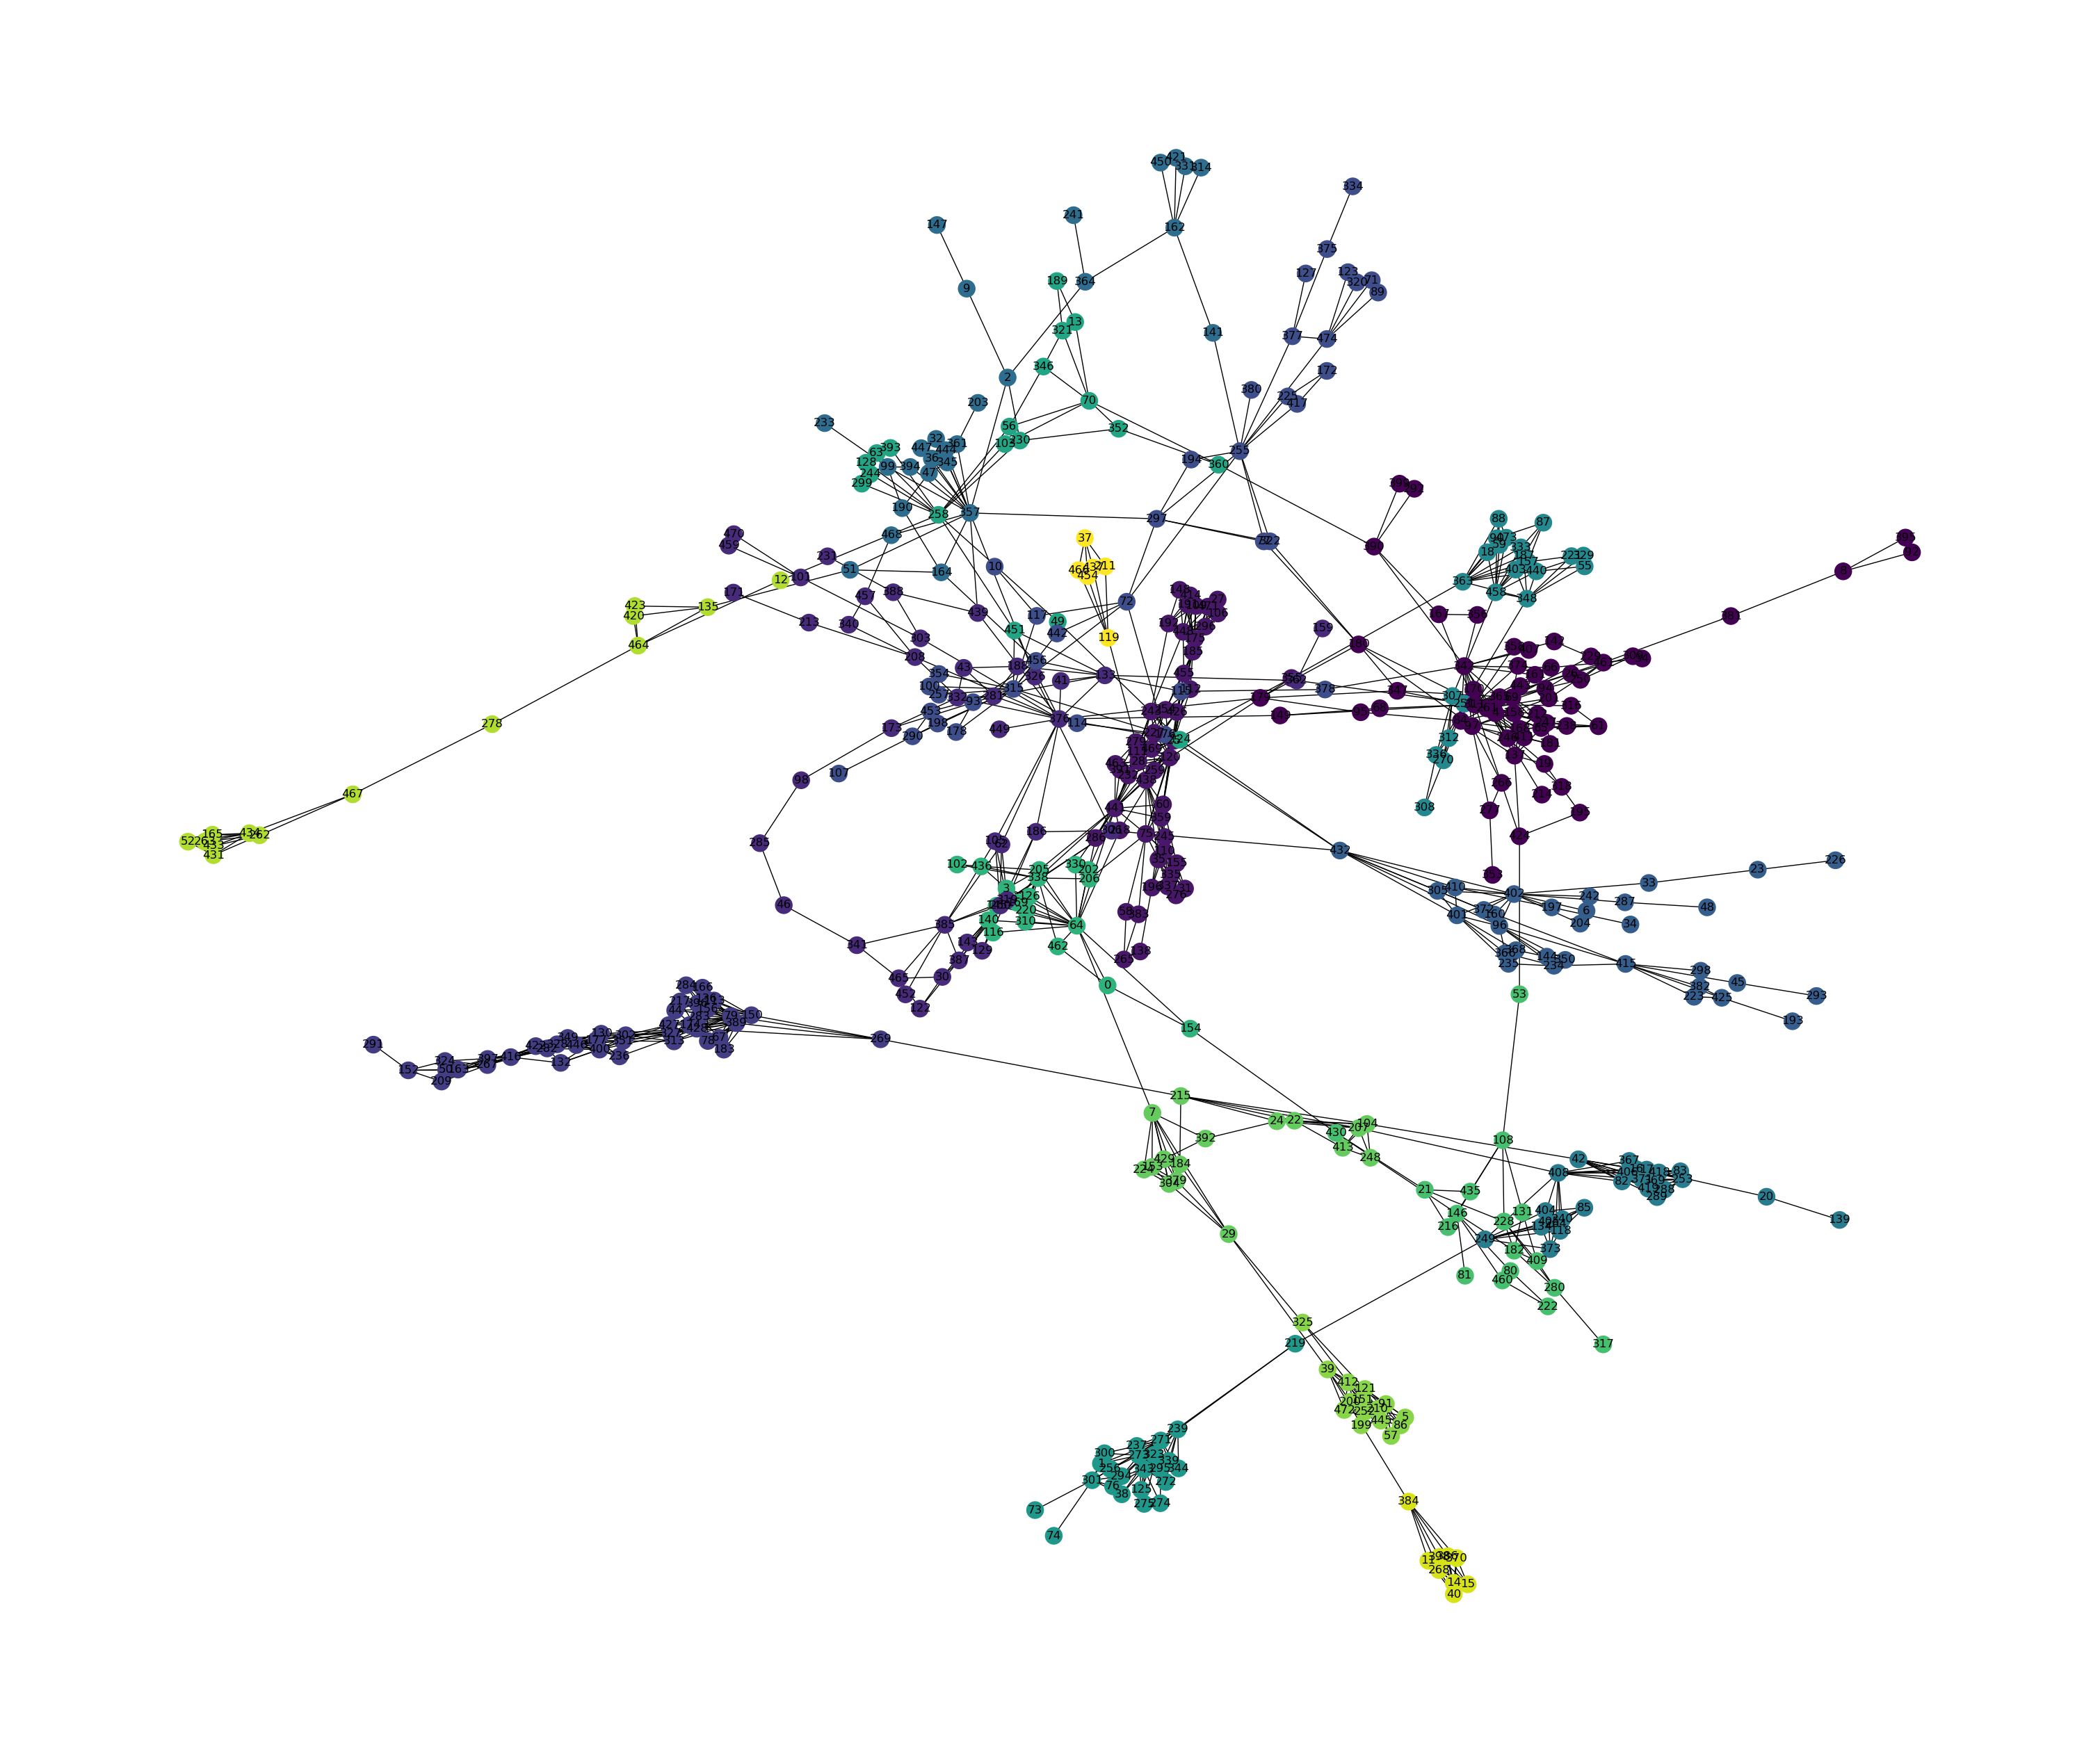

In [63]:
decoded = leiden_communities_belonging
es.plot(decoded)

### Plot de una solucion NSGA-II

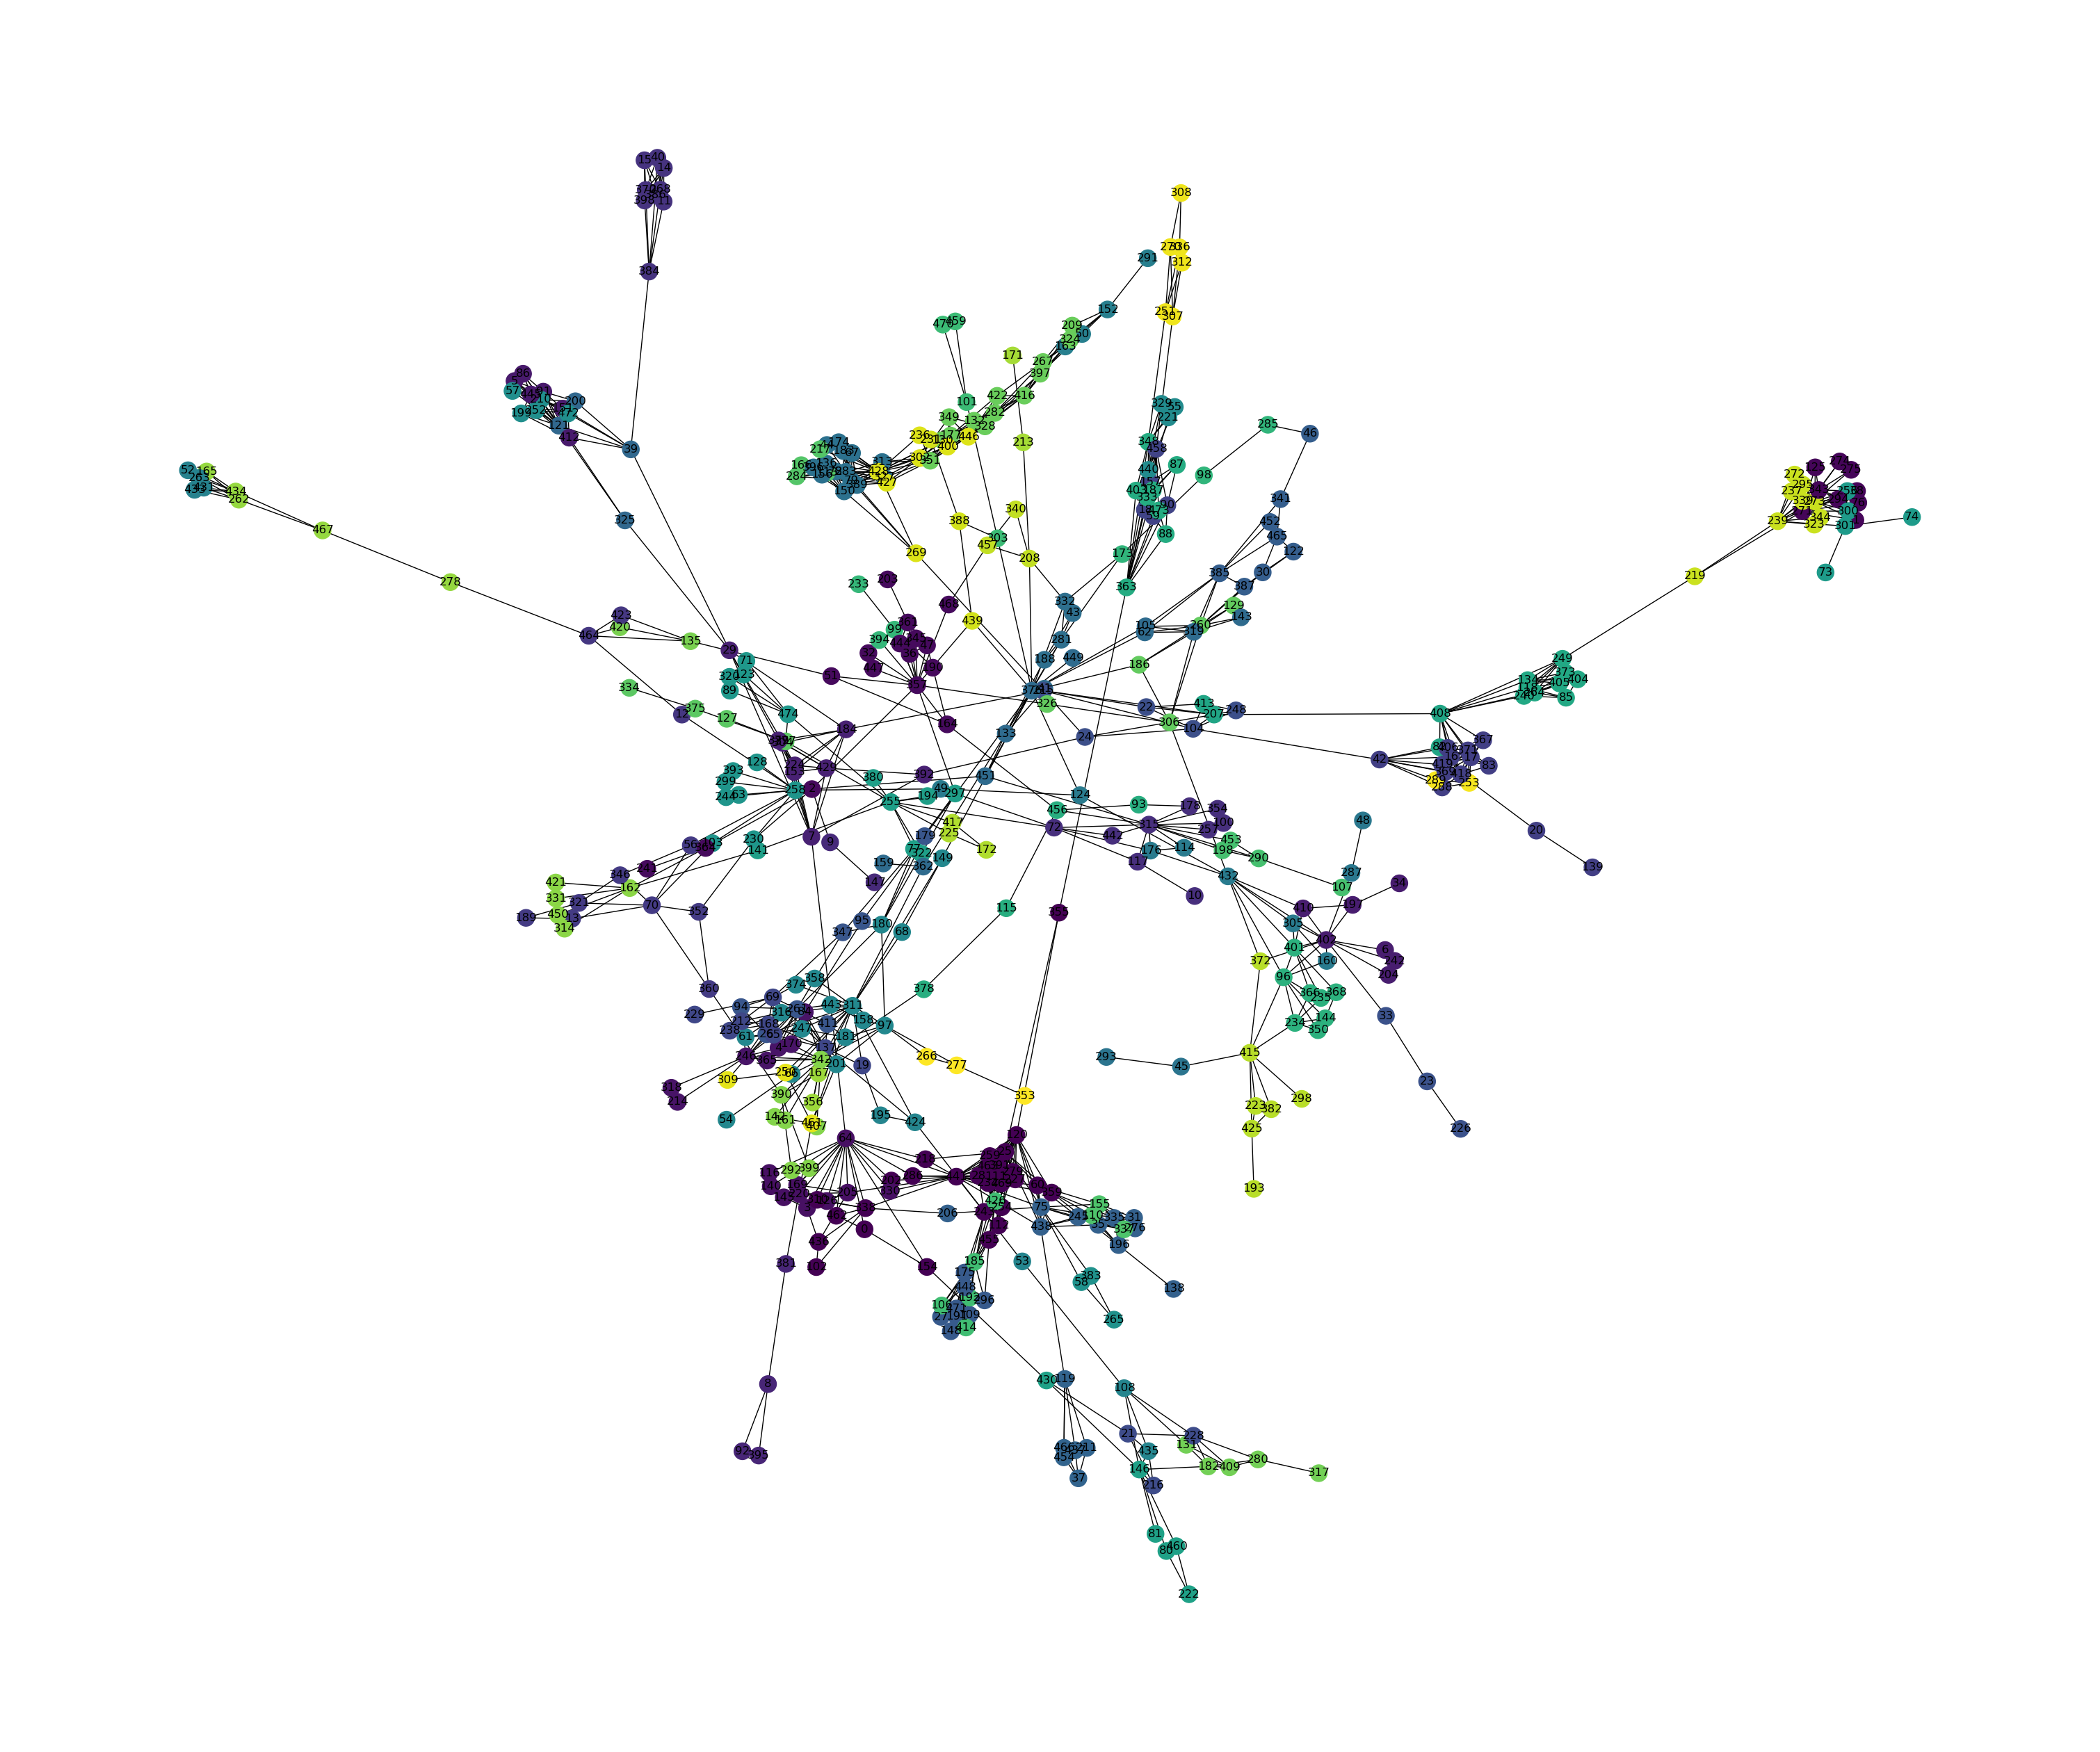

In [18]:
decoded = es.decode(pop[pareto[6]])
es.plot(decoded)

### Plot de una solucion MOGA

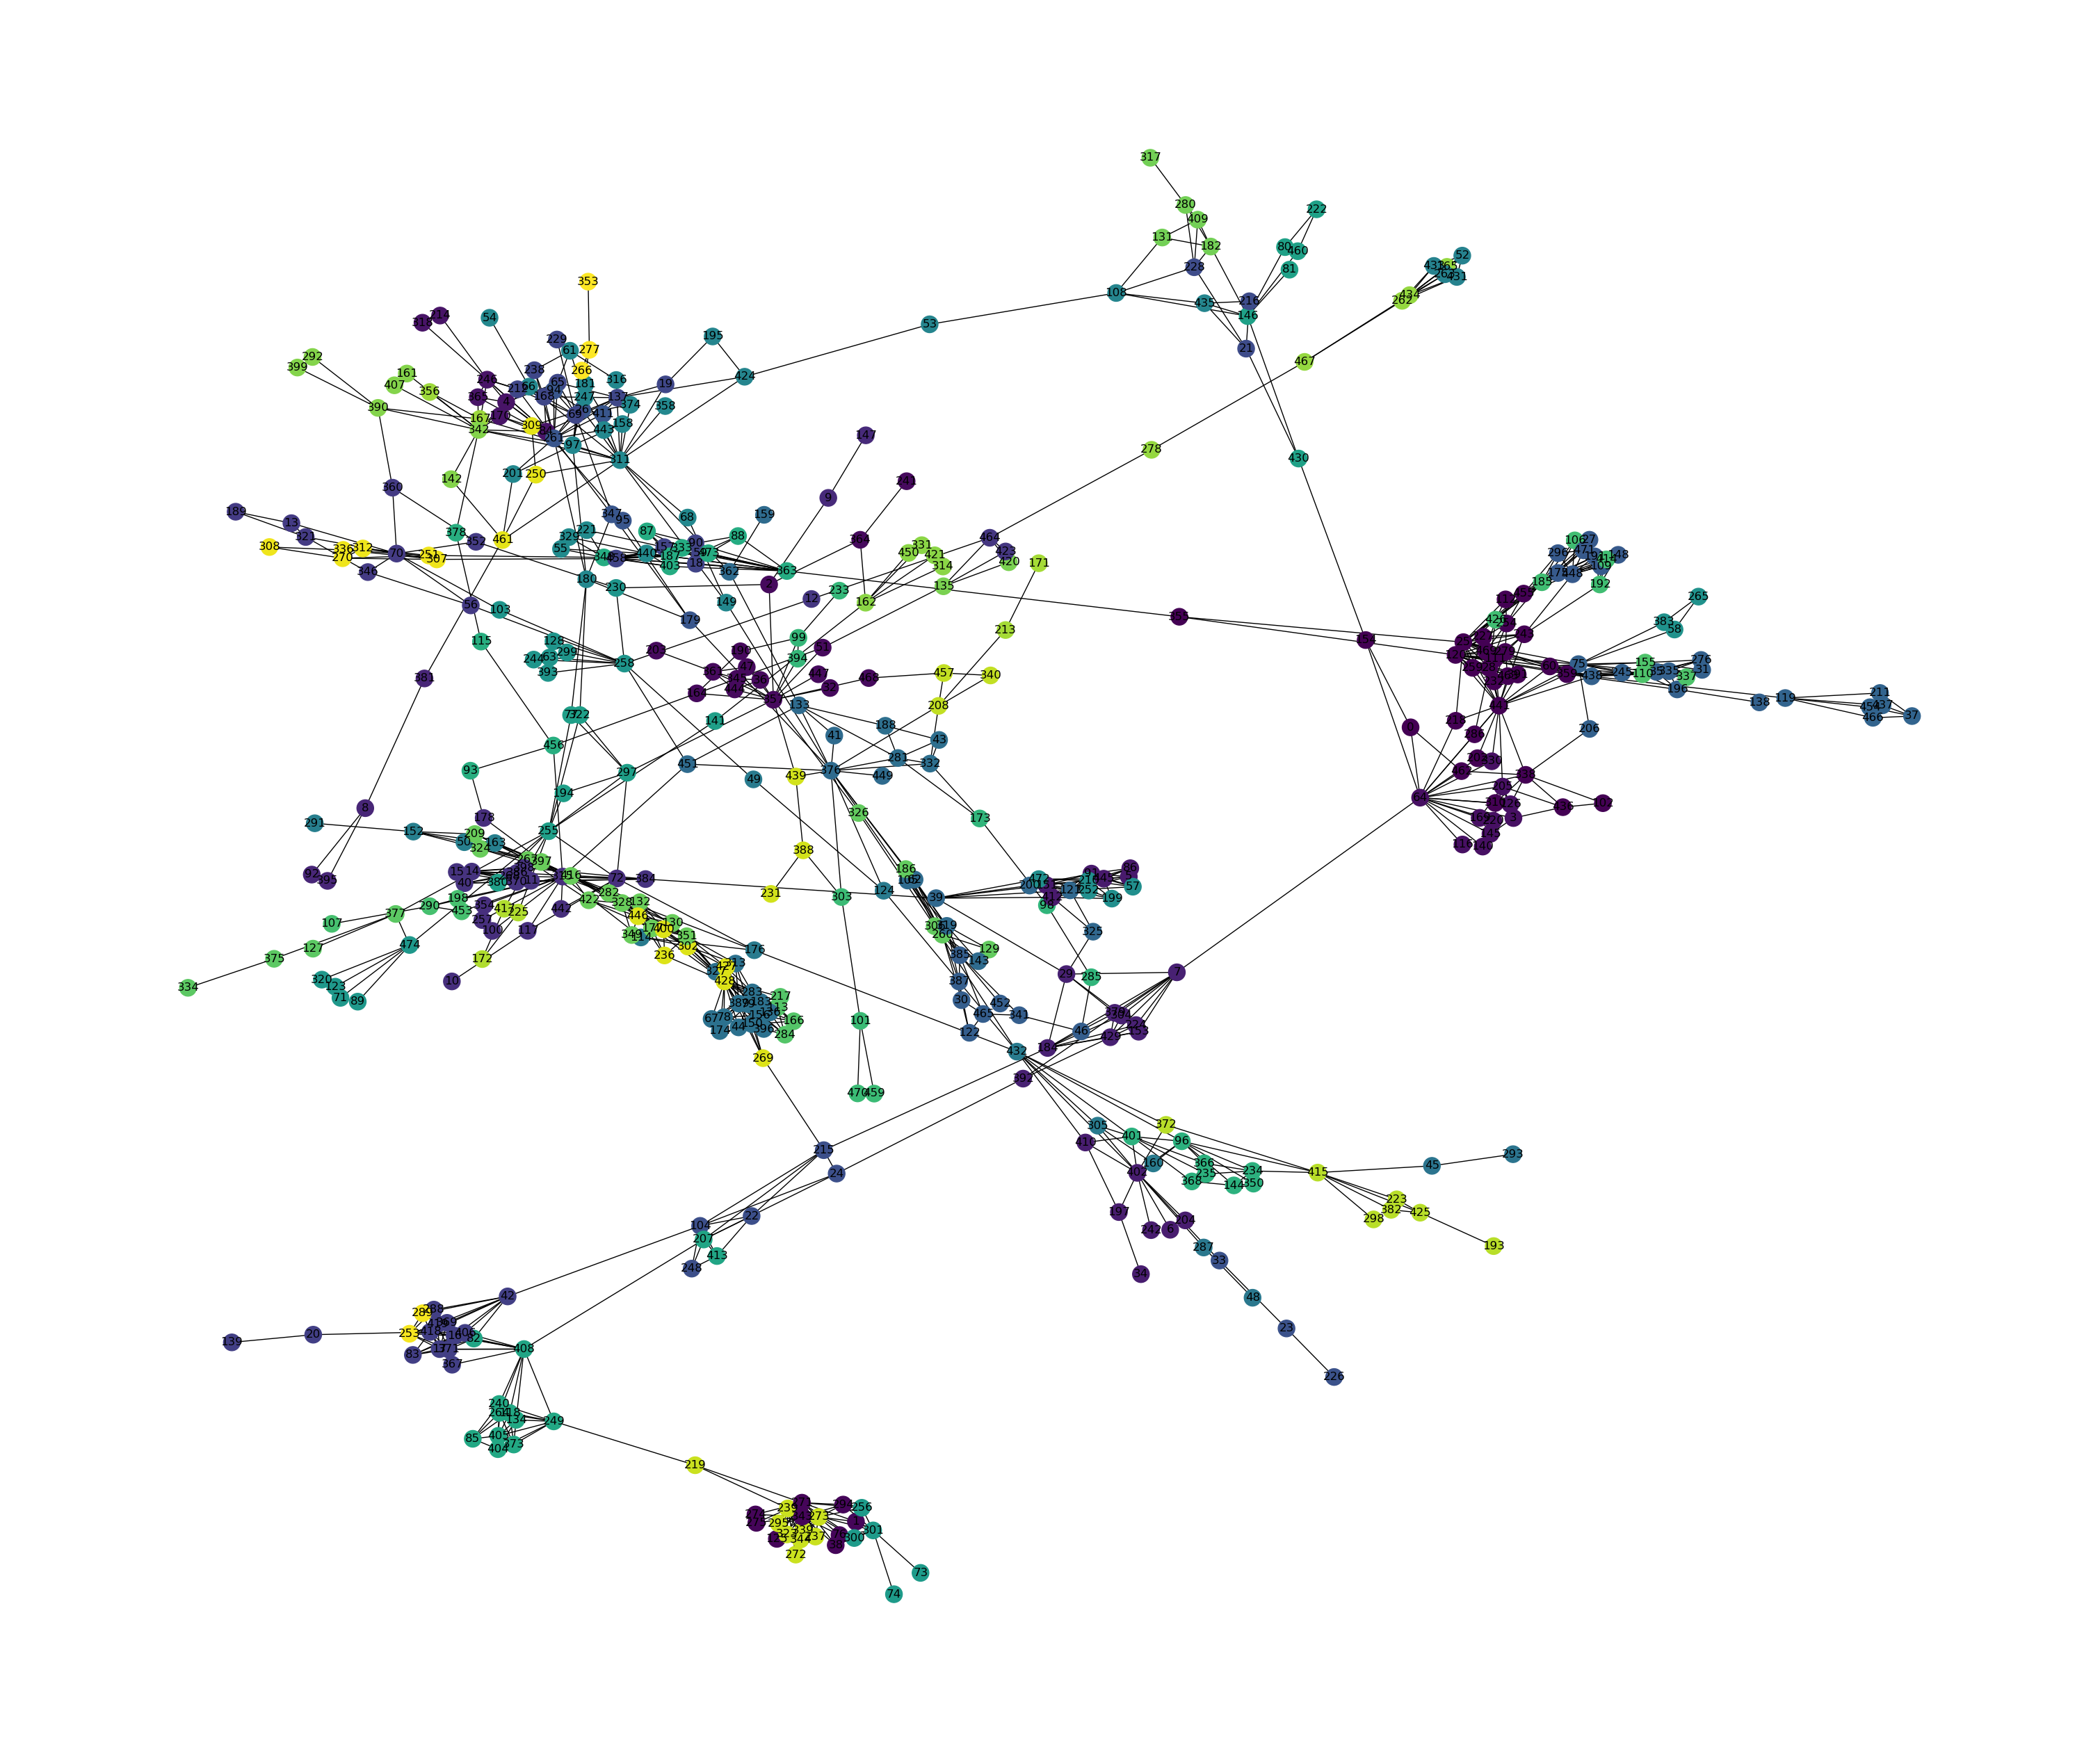

In [19]:
decoded = es.decode(pop2[pareto2[3]])
es.plot(decoded)

### Plot con ground truth

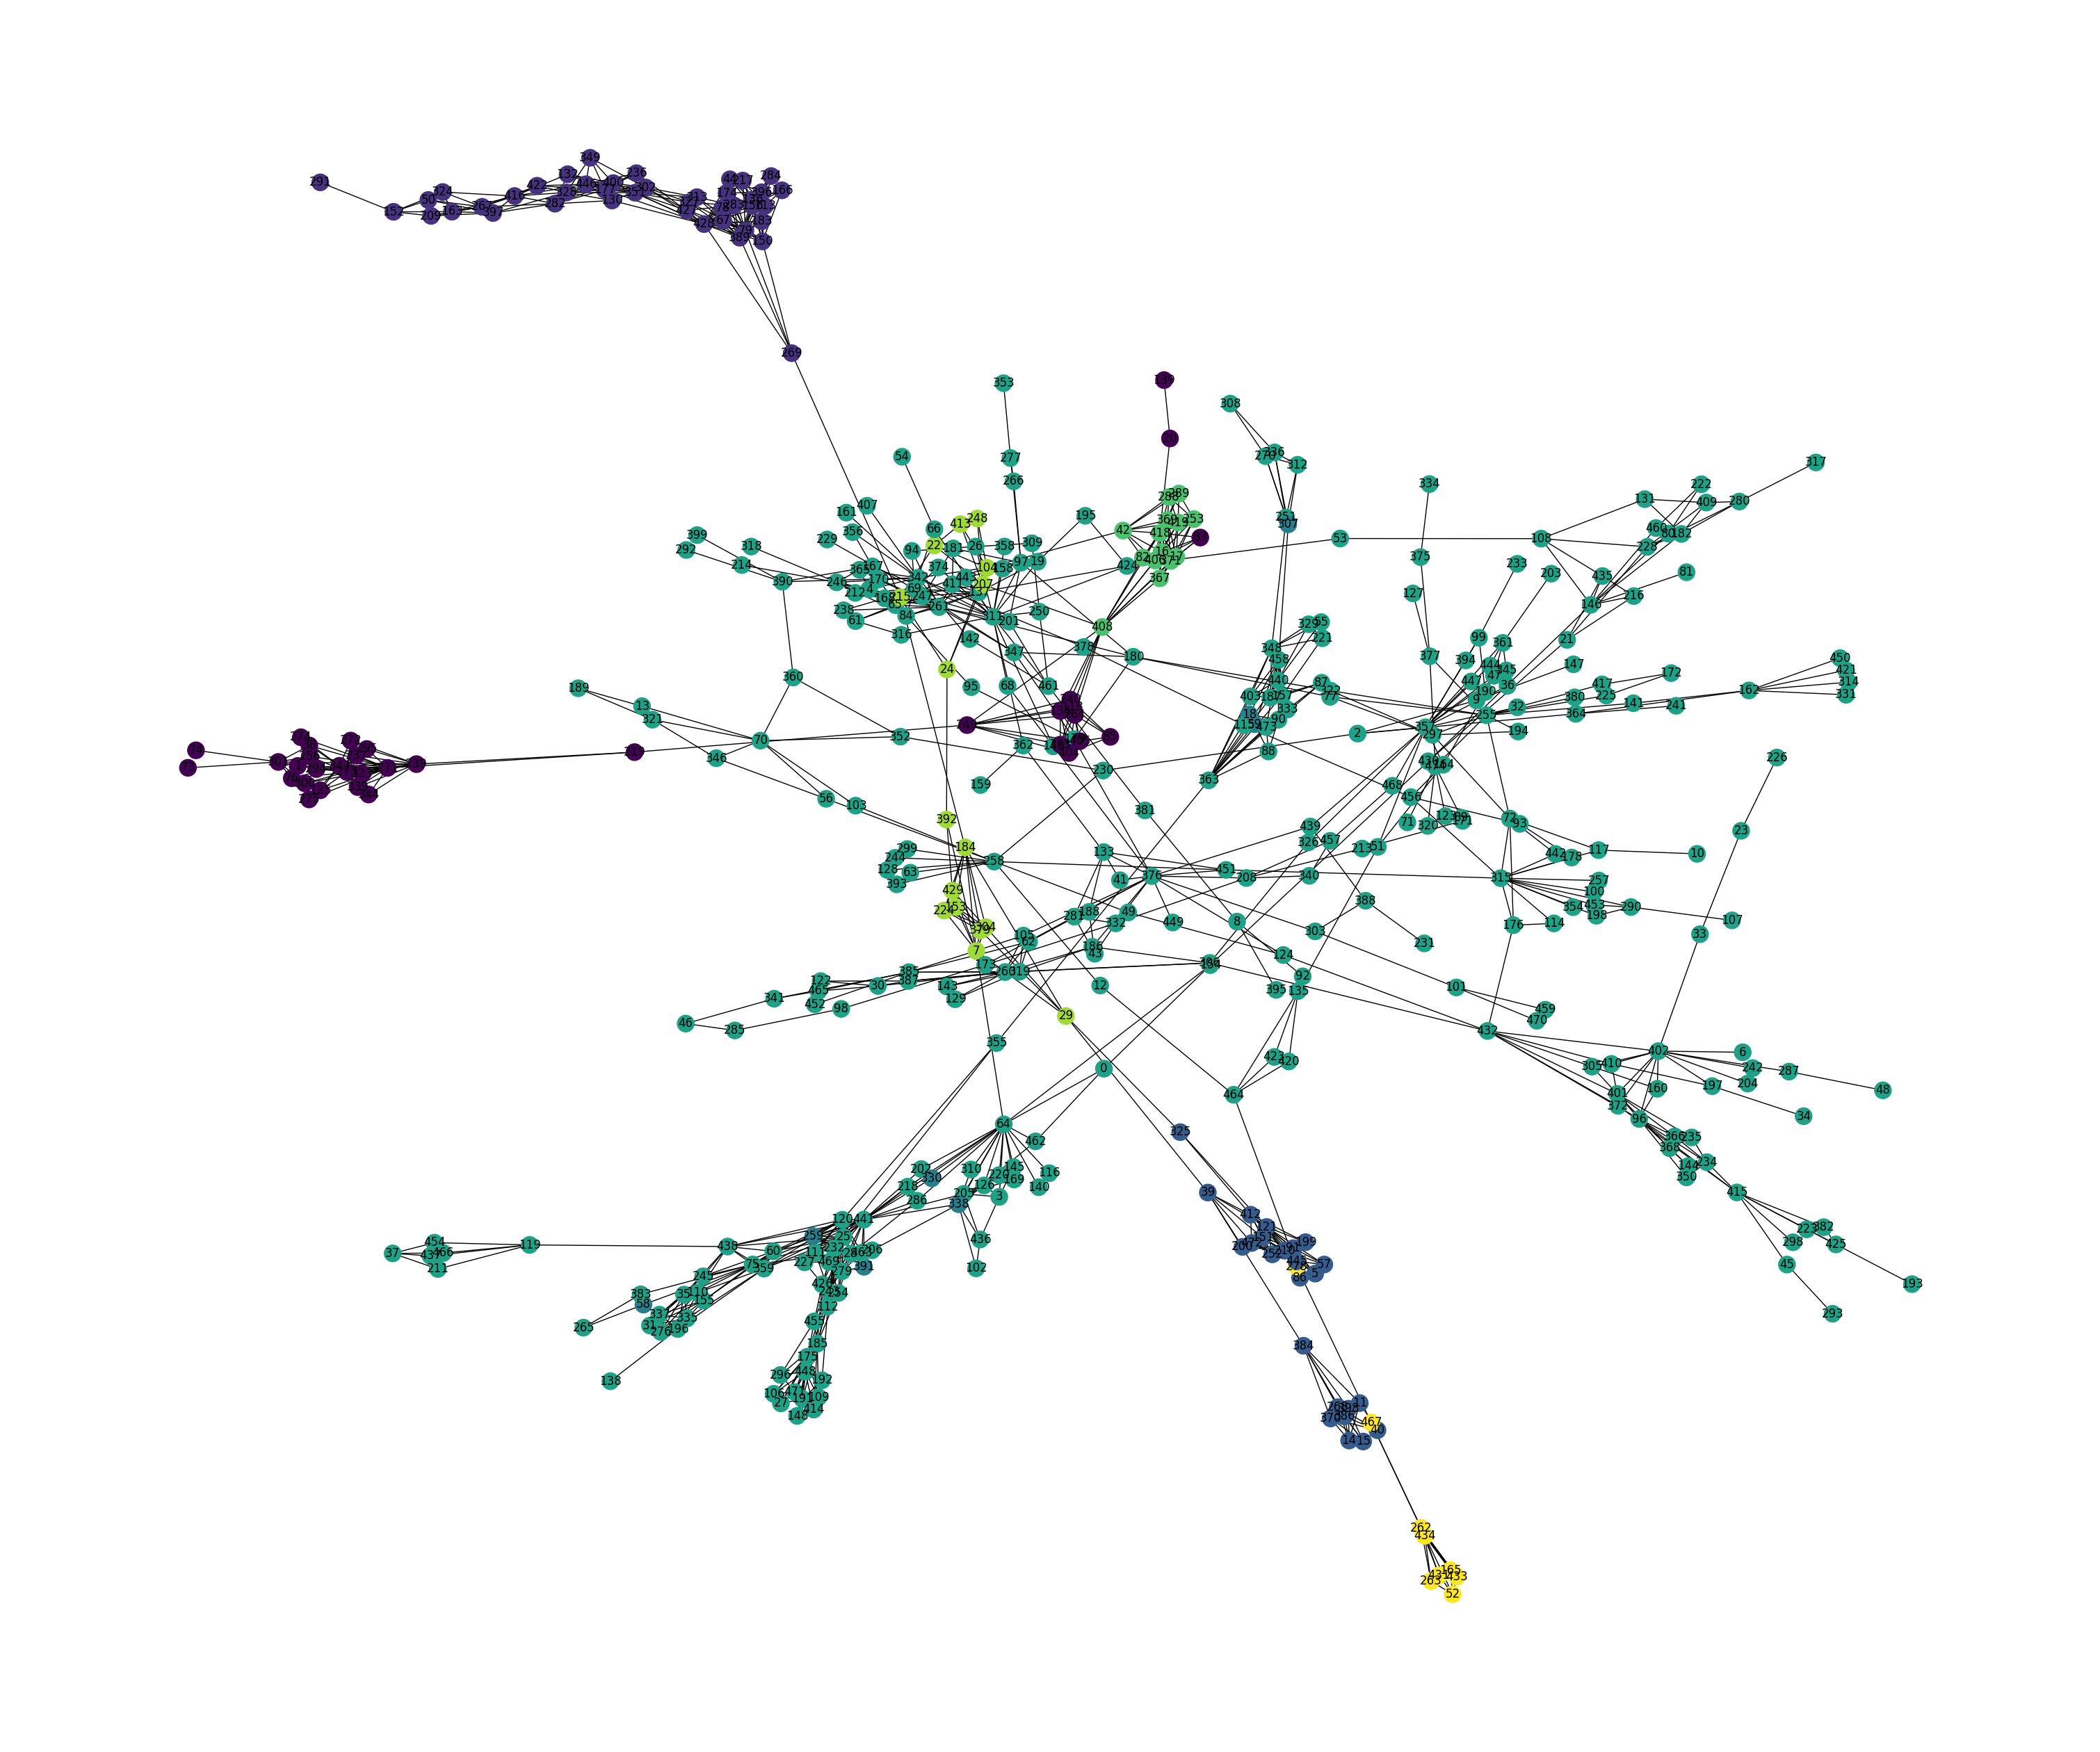

In [6]:
plt.figure(figsize=(30, 25))
nx.draw(graph, node_color=[data['community'] for _, data in graph.nodes(data=True)], with_labels=True)
plt.show()